In [1]:
import pandas as pd
import numpy as np
import edward as ed
import keras 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal, OneHotCategorical
from keras.models import Sequential, load_model
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_style('white')

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
white = pd.read_csv('../data/white.csv')
red = pd.read_csv('../data/red.csv')

red['type'] = 1
white['type'] = 0

wines = red.append(white, ignore_index = True)
print(wines.shape)

(6497, 13)


In [3]:
def neural_network(x, W_0, W_1, W_2, W_3,\
                   b_0, b_1, b_2, b_3):
    h = tf.nn.relu(tf.matmul(x, W_0) + b_0)
    h = tf.nn.relu(tf.matmul(h, W_1) + b_1)
    h = tf.nn.relu(tf.matmul(h, W_2) + b_2)
    h = tf.matmul(h, W_3) + b_3
    return h

## Data preprocessing

In [4]:
# Number of classes
K = 2

Features = np.array(wines[[c for c in wines.columns if c!='type']])
Labels = np.array(wines[['type']])
Labels = np.squeeze(np.eye(K,K,dtype=np.int32)[Labels,:])

X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size = .5, random_state = 42)

In [5]:
scalar = StandardScaler().fit(X_train)

X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

min_lengh = min(X_train.shape[0], X_test.shape[0])
X_train = X_train[:min_lengh, ]
y_train = y_train[:min_lengh, ]
X_test = X_test[:min_lengh, ]
y_test = y_test[:min_lengh, ]

In [6]:
print(X_train.shape)
print(y_train.shape)

(3248, 12)
(3248, 2)


# Build BNN model

In [7]:
ed.set_seed(47)

N = X_train.shape[0]
D = X_train.shape[1]

In [8]:
X = tf.placeholder(tf.float32, [N,D], name="X")

# Initialize the weights
W_0 = Normal(loc=tf.zeros([D, 12]), scale=tf.ones([D, 12]))
W_1 = Normal(loc=tf.zeros([12, 8]), scale=tf.ones([12, 8]))
W_2 = Normal(loc=tf.zeros([8, 8]), scale=tf.ones([8, 8]))
W_3 = Normal(loc=tf.zeros([8, K]), scale=tf.ones([8, K]))

b_0 = Normal(loc=tf.zeros(12), scale=tf.ones(12))
b_1 = Normal(loc=tf.zeros(8), scale=tf.ones(8))
b_2 = Normal(loc=tf.zeros(8), scale=tf.ones(8))
b_3 = Normal(loc=tf.zeros(K), scale=tf.ones(K))

Y = OneHotCategorical(logits=neural_network(X, W_0, W_1, W_2, W_3, b_0, b_1, b_2, b_3),
                      name="Y")

In [9]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, 12]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, 12])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [12, 8]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [12, 8])))
qW_2 = Normal(loc=tf.get_variable("qW_2/loc", [8, 8]),
              scale=tf.nn.softplus(tf.get_variable("qW_2/scale", [8, 8])))
qW_3 = Normal(loc=tf.get_variable("qW_3/loc", [8, K]),
              scale=tf.nn.softplus(tf.get_variable("qW_3/scale", [8, K])))


qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [12]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [12])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [8]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [8])))
qb_2 = Normal(loc=tf.get_variable("qb_2/loc", [8]),
              scale=tf.nn.softplus(tf.get_variable("qb_2/scale", [8])))
qb_3 = Normal(loc=tf.get_variable("qb_3/loc", [K]),
              scale=tf.nn.softplus(tf.get_variable("qb_3/scale", [K])))

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/zihaoxu/ENTER/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

{'t': 1, 'loss': 16304.827}
{'t': 101, 'loss': 1996.1759}
{'t': 201, 'loss': 1839.7888}
{'t': 301, 'loss': 1470.6918}
{'t': 401, 'loss': 506.48187}
{'t': 501, 'loss': 392.26807}
{'t': 601, 'loss': 488.99963}
{'t': 701, 'loss': 382.49625}
{'t': 801, 'loss': 382.4889}
{'t': 901, 'loss': 375.67456}


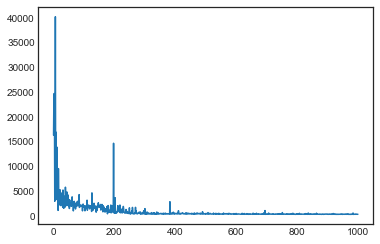

In [10]:
# Inference
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2,
                     W_3: qW_3, b_3: qb_3},
                    data={X:X_train,Y:y_train})
inference.initialize(n_iter=1000)

# Run
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
loss = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%100 == 0:
        print(info_dict)
    loss.append(info_dict['loss'])
plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig('../plots/loss_bnn', fmt = 'png', dpi = 300)

In [11]:
# Evaluation
Y_post = ed.copy(Y, {W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2,
                     W_3: qW_3, b_3: qb_3,})

print('Train accuracy: ',ed.evaluate('categorical_accuracy', data={X:X_train,Y_post:y_train}))
print('Test accuracy: ',ed.evaluate('categorical_accuracy', data={X:X_test,Y_post:y_test}))

/Users/zihaoxu/ENTER/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/zihaoxu/ENTER/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


Train accuracy:  0.99722904
Test accuracy:  0.9950739


In [12]:
# Use posterior mean of weighs and biases for prediction
W_0_p = qW_0.mean().eval()
W_1_p = qW_1.mean().eval()
W_2_p = qW_2.mean().eval()
W_3_p = qW_3.mean().eval()
b_0_p = qb_0.mean().eval()
b_1_p = qb_1.mean().eval()
b_2_p = qb_2.mean().eval()
b_3_p = qb_3.mean().eval()

In [13]:
# Convert dtype to float32 for testing 
X_test = np.array(X_test, dtype = np.float32)

# Prediction
y_pred = np.argmax(neural_network(X_test, W_0_p, W_1_p, W_2_p, W_3_p, \
                   b_0_p, b_1_p, b_2_p, b_3_p).eval(), axis = 1)
y_test = np.argmax(y_test, axis = 1)

Test acc: 0.9947660098522167


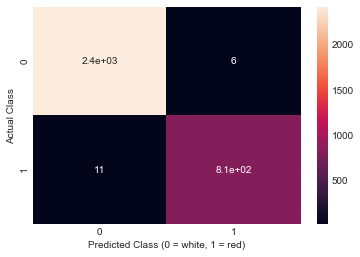

In [14]:
conf = confusion_matrix(y_test, y_pred)
print("Test acc:", (conf[0][0] + conf[1][1])/np.sum(conf))
sns.heatmap(conf, annot = True)
plt.xlabel("Predicted Class (0 = white, 1 = red)")
plt.ylabel("Actual Class")
plt.savefig('../plots/conf_bnn', fmt = 'png', dpi = 300)
plt.show()